In [304]:
from enum import Enum

import numpy as np

from skimage.filters import butterworth
from skimage.morphology import skeletonize
from skimage.measure import label
from skimage.feature import corner_subpix

from shapely.geometry import Polygon, LineString
from rdp import rdp

import math


Connectivity = Enum('Connectivity', 'FOUR EIGHT')


class WallPostProcessing():
    def __init__(self, logger=None):
        self.logger = logger


    def __reset_var(self):
        self.original_mask = None
        self.size = None
        self.mask = None
        self.skel = None

        self.coords = None
        self.coord_edges = None
        self.coord_degree = None

        self.coord_partitions = None
        self.door_bbox = None
        self.window_bbox = None
        self.furniture_bbox = None

        self.pixel_per_meter = -1

        self.room_mask = None
        self.graph = None


    def __call__(self, mask, symbol, **kwargs):
        self.__reset_var()

        self.door_bbox = []
        self.window_bbox = []
        self.furniture_bbox = []

        for b in symbol:
            if b['names'] == 'Door':
                self.door_bbox.append(b['bounding_box_n'])
            elif b['names'] == 'Window':
                self.window_bbox.append(b['bounding_box_n'])
            else:
                self.furniture_bbox.append(b['bounding_box_n'])

        self.original_mask = mask
        self.size = np.array(mask.shape)

        self._mask_skeleton(mask.copy(), **kwargs)

        self._find_skeleton_edges(**kwargs)

        self._graph_partitioning(**kwargs)
        self._polygon_simplification(**kwargs)
        
        self._thickness_abduction(**kwargs)
        self._wall_selection(**kwargs)
        self._angle_refinement(**kwargs)

        self._wall_regularization(**kwargs)
        self._door_abduction(**kwargs)

        coords = self.coords.copy().astype(float)

        coords[:,0] = coords[:,0] / self.size[0]
        coords[:,1] = coords[:,1] / self.size[1]

        self._room_masking(**kwargs)
        self._graph_construction()

        return self.graph, self.coords, self.coord_edges


    def _is_valid_point(self, point):
        return (point >= np.zeros(2, dtype=np.int32)).all(-1) and (point < self.size).all(-1)


    def _mask_skeleton(
        self,
        mask,
        _mask_skeleton_cutoff_frequency_ratio=0.16,
        _mask_skeleton_order=8.0,
        _mask_skeleton_confidence_value=0.3,
        _door_width_regulation=0.85,
        **kwargs
    ):
        mask[[0, -1],:] = 0
        mask[:,[0, -1]] = 0

        mask = (mask + mask.min()) / (mask.max() + mask.min())

        kwargs = {
            'cutoff_frequency_ratio': _mask_skeleton_cutoff_frequency_ratio,
            'order': _mask_skeleton_order,
            'high_pass': False
        }
        self.mask = butterworth(mask, **kwargs) >= _mask_skeleton_confidence_value

        door_widths = []
        for bbox in self.door_bbox:
            x1 = int(self.size[1] * bbox[0])
            y1 = int(self.size[0] * bbox[1])
            x2 = int(self.size[1] * bbox[2])
            y2 = int(self.size[0] * bbox[3])
            width = max(x2 - x1, y2 - y1)
            door_widths.append(width)
            self.mask[y1:y2, x1:x2] = 1
        median_width = np.median(door_widths)
        self.pixel_per_meter = median_width / _door_width_regulation
        
        self.skel = skeletonize(self.mask)


    def _find_skeleton_edges(
        self,
        _skeleton_edge_connectivity_type=Connectivity.EIGHT,
        **kwargs
    ):
        assert (_skeleton_edge_connectivity_type in [Connectivity.FOUR, Connectivity.EIGHT])

        coords = np.argwhere(self.skel)
        coords_idx = np.zeros_like(self.skel) - 1
        coords_LEN = len(coords)

        for idx,[x,y] in enumerate(coords):
            coords_idx[x,y] = idx

        if _skeleton_edge_connectivity_type == Connectivity.EIGHT:
            connectivity = np.array([
                [0, 0, 1, 1, 1, -1, -1, -1],
                [1, -1, 0, 1, -1, 0, 1, -1]
            ]).T
        else:
            connectivity = np.array([
                [0, 0, 1, -1],
                [1, -1, 0, 0]
            ]).T

        coord_edges = []
        coord_degree = np.zeros((coords_LEN), dtype=np.int8)

        for _ in range(coords_LEN):
            coord_edges.append([])

        for idx,point in enumerate(coords):
            for connection in connectivity:
                next_point = point + connection

                if not self._is_valid_point(next_point):
                    continue

                next_target = coords_idx[next_point[0], next_point[1]]

                if next_target > -1:
                    coord_edges[idx].append(next_target)
                    coord_degree[idx] += 1
        
        self.coords = coords
        self.coord_edges = coord_edges
        self.coord_degree = coord_degree


    def _graph_partitioning(
        self,
        **kwargs
    ):
        coords_LEN = len(self.coords)

        static_points = np.where(self.coord_degree > 2)[0]
        if static_points.shape[0] == 0:
            static_points = np.random.choice(np.where(self.coord_degree > 1)[0], 1)

        visited = np.zeros((coords_LEN), dtype=np.bool_)
        self.coord_partitions = []

        for point in static_points:
            if visited[point]:
                continue

            queue = []
            queue.append(point)
            while len(queue) > 0:
                current = queue.pop(0)
                visited[current] = True

                for next_coord in self.coord_edges[current]:
                    if visited[next_coord]:
                        continue

                    # create new partition
                    partition = [current]
                    part_current = current
                    part_next = next_coord

                    while True:
                        part_current = part_next
                        partition.append(part_current)
                        if self.coord_degree[part_current] != 2 or part_current == current:
                            break

                        visited[part_current] = True
                        for conn in self.coord_edges[part_current]:
                            if visited[conn]:
                                continue
                            part_next = conn


                    self.coord_partitions.append(partition)
                    if self.coord_degree[part_current] > 2:
                        queue.append(part_current)


    def _polygon_simplification(
        self,
        _rdp_epsilon=0.1,
        _corner_subpix_window_size=48,
        _nms_radius=0.2,
        _nms_threshold=0.5,
        **kwargs
    ):
        _rdp_epsilon = self.pixel_per_meter * _rdp_epsilon
        _nms_radius = int(self.pixel_per_meter * _nms_radius)
        coords_LEN = len(self.coords)
        connections = []
        used_coords = []
        for partition in self.coord_partitions:
            partition = np.array(partition)
            partition_mask = rdp(self.coords[partition], epsilon=_rdp_epsilon, return_mask=True)
            new_partition = partition[partition_mask]
            used_coords_partition = []
            for coord in new_partition:
                used_coords_partition.append(coord)
            for idx in range(1, len(new_partition)):
                connections.append([new_partition[idx - 1], new_partition[idx]])
            used_coords += used_coords_partition

        inverse_used_coords = np.zeros((coords_LEN), dtype=np.int32) - 1
        for i,coord in enumerate(used_coords):
            inverse_used_coords[coord] = i
        for i,[u,v] in enumerate(connections):
            connections[i] = [
                inverse_used_coords[u],
                inverse_used_coords[v]
            ]

        before_subpix_coords = self.coords[used_coords]
        coords = corner_subpix(self.skel, before_subpix_coords, window_size=_corner_subpix_window_size).round()
        for idx,[x,y] in enumerate(coords):
            if math.isnan(x):
                coords[idx] = before_subpix_coords[idx]
        coords = coords.astype(np.int32)

        coords, mask_coords = self._non_max_suppression(coords, _nms_radius, _nms_threshold)

        connections = np.unique(
            np.array([
                [mask_coords[u], mask_coords[v]] for [u,v] in connections
            ])
        , axis=0)

        delete_connection = np.where(connections[:,0] == connections[:,1])
        connections = np.delete(connections, delete_connection, axis=0)

        self.coord_edges = connections
        self.coords = coords


    def _non_max_suppression(self, center, radius, overlapThresh):
        if len(center) == 0:
            return []
        double_rad_ = 2 * radius + 1
        center = center.astype(np.float32)
        pick = []
        
        area = double_rad_ * double_rad_
        idxs = np.argsort(center[:,1])
        mapper = np.empty(center.shape[0], dtype=np.int32)
        
        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            new_id = len(pick)
            pick.append(i)

            x1 = np.maximum(center[i,0], center[idxs[:last],0])
            y1 = np.maximum(center[i,1], center[idxs[:last],1])
            x2 = np.minimum(center[i,0], center[idxs[:last],0])
            y2 = np.minimum(center[i,1], center[idxs[:last],1])

            w = np.clip(x2 - x1 + double_rad_, a_min=0, a_max=None)
            h = np.clip(y2 - y1 + double_rad_, a_min=0, a_max=None)

            overlap = (w * h) / area

            must_delete = np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
            mapper[idxs[must_delete]] = new_id
            idxs = np.delete(idxs, must_delete)
            
        return center[pick].round().astype(np.int32), mapper
    
    
    def _thickness_abduction(
        self,
        _thickness_abduction_sample_size=10,
        **kwargs
    ):
        coord_edges = []
        for [u,v] in self.coord_edges:
            point_vector = self.coords[u] - self.coords[v]
            dist = np.linalg.norm(point_vector)
            normalized_vector = point_vector / dist
            perpendicular_vector = normalized_vector[::-1] * np.array([1, -1])

            sample = min(_thickness_abduction_sample_size, int(dist) + 1)
            coords = [(self.coords[v] + (point_vector * i / sample)).round().astype(np.int32) for i in range(sample)]

            sample_width = np.array([self._thickness_search_naive(c, perpendicular_vector) for c in coords])
            median_width = np.median(sample_width).round()
            wall_thickness = 2 * median_width + 1
            coord_edges.append([u, v, wall_thickness])
        self.coord_edges = np.array(coord_edges, dtype=np.int32)


    def _thickness_search_naive(self, c, p):
        c1, c2 = c.copy(), c.copy()
        white_point = lambda x: self._is_valid_point(x) and self.mask[x[0], x[1]]

        outer_r = 0
        inner_r = 0
        inc = 1
        while white_point(c1) or white_point(c2):
            outer_r += inc
            if white_point(c1) and white_point(c2):
                inner_r += inc
            c1 = (c - outer_r * p).astype(np.int32)
            c2 = (c + outer_r * p).astype(np.int32)

        return int((outer_r + inner_r) / 2)


    def _wall_selection(
        self,
        _wall_thickness_threshold=0.08,
        _disconnected_wall_length_threshold=0.3,
        _connected_wall_length_threshold=0.1,
        **kwargs
    ):
        coords = self.coords.copy()
        coord_edges = []
        mask = np.arange(len(coords))
        used_coords = np.zeros(len(coords), dtype=np.int32) - 1
        coord_degree = np.zeros(len(coords), dtype=np.int32)

        def find_mask(x):
            if mask[x] != x:
                mask[x] = find_mask(mask[x])
            return mask[x]

        for [u,v,w] in self.coord_edges:
            coord_degree[u] += 1
            coord_degree[v] += 1
        
        for [u,v,w] in self.coord_edges:
            dis = coord_degree[u] <= 1 or coord_degree[v] <= 1
            if w < _wall_thickness_threshold * self.pixel_per_meter:
                continue

            c1 = coords[u]
            c2 = coords[v]
            d = np.linalg.norm(c2 - c1)

            if (dis and d >= _disconnected_wall_length_threshold * self.pixel_per_meter) or (not dis and d >= _connected_wall_length_threshold * self.pixel_per_meter):
                coord_edges.append([u,v,w])
                continue

            if not dis:
                u = find_mask(u)
                v = find_mask(v)
                mask[u] = v

        used_idx = 0
        for idx,[u,v,w] in enumerate(coord_edges):
            u = find_mask(u)
            v = find_mask(v)
            if used_coords[u] < 0:
                used_coords[u] = used_idx
                used_idx += 1
            if used_coords[v] < 0:
                used_coords[v] = used_idx
                used_idx += 1
            coord_edges[idx][0] = used_coords[u]
            coord_edges[idx][1] = used_coords[v]

        inv_used_coord = np.zeros(used_idx, dtype=np.int32)
        for i,num in enumerate([u for u in used_coords]):
            if num > -1:
                inv_used_coord[num] = i

        coords = coords[inv_used_coord]
        self.coords = coords
        self.coord_edges = np.array(coord_edges)

    
    def _angle_refinement(
        self,
        _angle_divider_count=24,
        _refined_threshold=0.7,
        _max_iter=50,
        **kwargs
    ):
        grad16 = np.around([[
            np.sin(i * np.pi * 2 / _angle_divider_count),
            np.cos(i * np.pi * 2 / _angle_divider_count),
        ] for i in range(_angle_divider_count)], decimals=5)

        change = self.coord_edges.shape[0]
        iteration = 0
        while change > (1 - _refined_threshold) * self.coord_edges.shape[0]:
            iteration += 1
            if iteration > _max_iter:
                break
            change = 0
            for [u,v,w] in self.coord_edges:
                cu = self.coords[u]
                cv = self.coords[v]

                dist = np.linalg.norm(cu - cv)
                norm_vector = (cu - cv) / dist
                preferred_grad_index = np.argmin(np.abs(grad16 - norm_vector).sum(axis=1))
                preferred_grad = grad16[preferred_grad_index]

                fixed = (cu + cv) / 2
                dv = fixed - dist * preferred_grad / 2
                du = fixed + dist * preferred_grad / 2

                dv = dv.round().astype(np.int32)
                du = du.round().astype(np.int32)

                if not ((du == cu).all() and (dv == cv).all()):
                    change += 1
                    self.coords[u] = du
                    self.coords[v] = dv


    def _wall_regularization(
        self,
        **kwargs
    ):
        thickness = np.sort([w for [u,v,w] in self.coord_edges])
        
        # jenks natural break optimization (k means for 1D)
        opt_i = 0
        stdev_sum = np.std(thickness)
        for i in range(len(thickness)):
            cls1 = thickness[:i]
            cls2 = thickness[i:]
            
            std = np.std(cls1) + np.std(cls2)
            if std < stdev_sum:
                stdev_sum = std
                opt_i = i

        th1 = np.mean(thickness[:opt_i])
        th2 = np.mean(thickness[opt_i:])
        lim = (thickness[opt_i] + thickness[opt_i + 1]) / 2

        for idx,[u,v,w] in enumerate(self.coord_edges):
            w = th1 if w < lim else th2
            self.coord_edges[idx][2] = w


    def _point_distance_to_segment(
        self,
        point,
        segment_u,
        segment_v
    ):
        segment_vector = segment_v - segment_u
        point_vector = point - segment_u
        proj = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)
        proj = min(1, max(0, proj))
        nearest = segment_u + proj * segment_vector
        return np.linalg.norm(point - nearest), nearest, proj


    def _object_length_abduction(
        self,
        center,
        vector,
        bbox,
        thickness
    ):
        vector = vector / np.linalg.norm(vector)
        bbox_poly = Polygon([(bbox[1], bbox[0]), (bbox[1], bbox[2]), (bbox[3], bbox[2]), (bbox[3], bbox[0])])
        half_w = 1
        current_iou = 0
        max_iou = -1
        while current_iou >= max_iou:
            max_iou = current_iou
            half_w += 1
            
            u = center + half_w * vector
            v = center - half_w * vector

            line = LineString([(u[0], u[1]), (v[0], v[1])])
            obj_poly = line.buffer(thickness, cap_style=2)

            current_iou = bbox_poly.intersection(obj_poly).area / bbox_poly.union(obj_poly).area
        return 2 * half_w


    def _door_abduction(
        self,
        **kwargs
    ):
        coord_edges = []

        for [u,v,w] in self.coord_edges:
            coord_edges.append({
                'vertices': [u, v],
                'thickness_pixel': w,
                'thickness_meter': w / self.pixel_per_meter,
                'doors': [],
                'windows': []
            })

        for llist,nlist in [(self.door_bbox, 'doors'), (self.window_bbox, 'windows')]:
            for bbox in llist:
                bbox[1::2] = bbox[1::2] * self.size[0]
                bbox[0::2] = bbox[0::2] * self.size[1]
                center = np.array([(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2])

                nearest_segment = 0
                min_dist = (self.size * self.size).sum()
                nearest_point = None
                projection = None

                for segment_idx,[u,v,w] in enumerate(self.coord_edges):
                    d, near, proj = self._point_distance_to_segment(center, self.coords[u], self.coords[v])
                    if d < min_dist:
                        min_dist = d
                        nearest_segment = segment_idx
                        nearest_point = near
                        projection = proj

                [u,v,w] = self.coord_edges[nearest_segment]
                vector = self.coords[u] - self.coords[v]
                
                length = self._object_length_abduction(nearest_point, vector, bbox, w)

                coord_edges[nearest_segment][nlist].append({
                    'center': nearest_point,
                    'projection': projection,
                    'length': length,
                    'bbox': bbox,
                })
        self.coord_edges = coord_edges


    def _room_masking(
        self,
        **kwargs
    ):
        pad = int(max([a['thickness_pixel'] for a in self.coord_edges]))
        mask = np.zeros(self.size + 2 * pad, dtype=np.int32)
        mask[pad:self.size[0]+pad, pad:self.size[1]+pad] = self.skel.copy()
        mask ^= 1
        
        mask = label(mask, connectivity=1)
        self.room_mask = mask - 1


    def _graph_construction(
        self,
        **kwargs
    ):
        for edge in self.coord_edges:
            vertices = edge['vertices']
            thickness_pixel = edge['thickness_pixel']

            for door in edge['doors']:
                projection = door['projection']
                

In [305]:
np.sort([1, 2, 3])

array([1, 2, 3])

In [306]:
import pickle

with open('segment.pkl', 'rb') as f:
    segment = pickle.load(f)
with open('symbol.pkl', 'rb') as f:
    symbol = pickle.load(f)

In [307]:
from PIL import Image, ImageDraw

def draw_skel(coords, coord_edges, shape):
    image = Image.new('RGB', (shape[1], shape[0]))
    draw = ImageDraw.Draw(image)
    for conn in coord_edges:
        vertices = conn['vertices']
        thickness_pixel = conn['thickness_pixel']
        u = coords[vertices[0],::-1].round().astype(np.int32)
        v = coords[vertices[1],::-1].round().astype(np.int32)
        vector = (u - v) / np.linalg.norm(u - v)

        draw.line((tuple(u), tuple(v)), fill=(255,255,255), width=thickness_pixel)

        doors = conn['doors']
        windows = conn['windows']

        for door in doors:
            center = door['center'][::-1]
            length = door['length']
            proj = door['projection']
            bbox = door['bbox']

            u_door = (u + proj * (v - u) - length * vector / 2).round().astype(np.int32)
            v_door = (u + proj * (v - u) + length * vector / 2).round().astype(np.int32)
            draw.line((tuple(u_door), tuple(v_door)), fill=(255,0,0), width=thickness_pixel)
        for door in windows:
            center = door['center'][::-1]
            length = door['length']
            proj = door['projection']
            bbox = door['bbox']

            u_door = (u + proj * (v - u) - length * vector / 2).round().astype(np.int32)
            v_door = (u + proj * (v - u) + length * vector / 2).round().astype(np.int32)
            draw.line((tuple(u_door), tuple(v_door)), fill=(0,255,0), width=thickness_pixel)
    return image

def show(img):
    if img.dtype.kind == 'b':
        img = img.astype(np.int32)
    display(Image.fromarray((((img - img.min()) / (img.max() - img.min())) * 255).astype(np.uint8)))

In [308]:
a = np.array([698, 1125])
b = np.array([692, 1121])
c = np.zeros(2)

(b >= c).all(-1) and (b < a).all(-1)

True

c:\Users\ChristianBudhiS\miniconda3\envs\ta-env\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ChristianBudhiS\miniconda3\envs\ta-env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ChristianBudhiS\miniconda3\envs\ta-env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


65.88235294117648


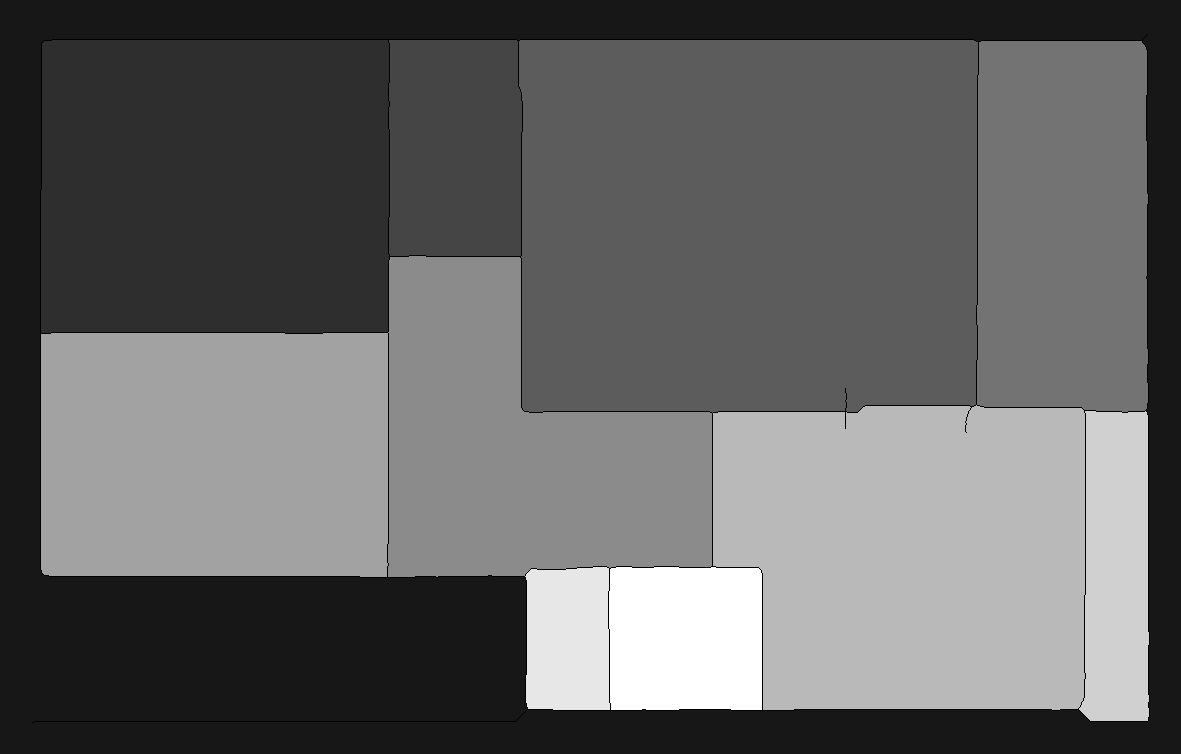

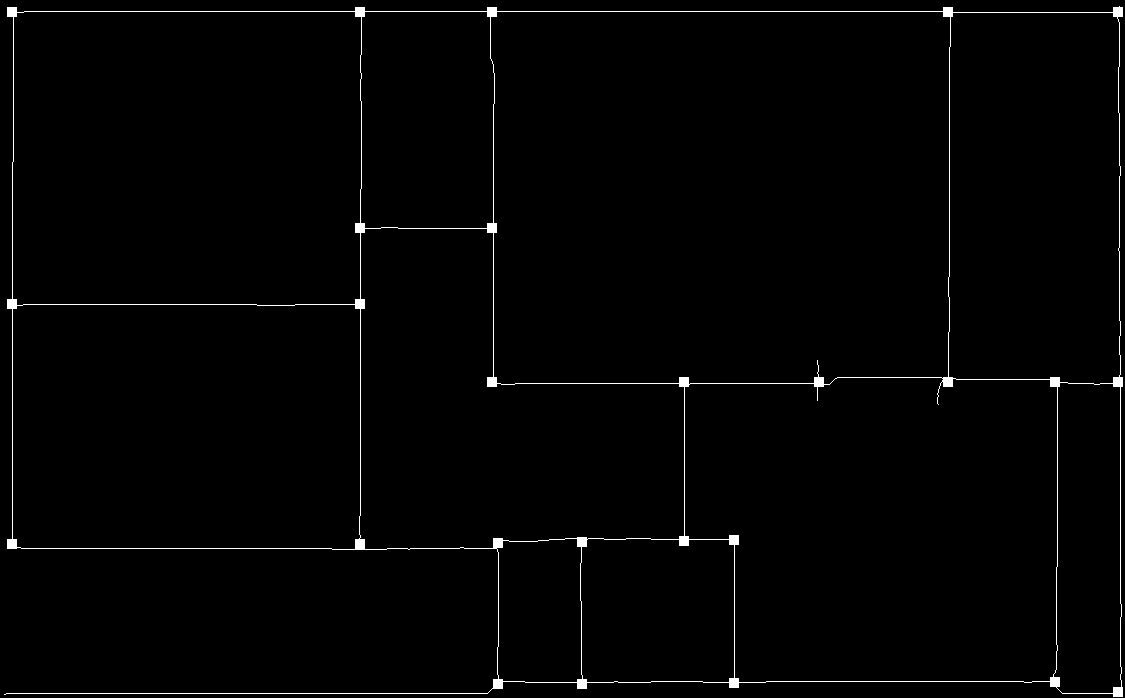

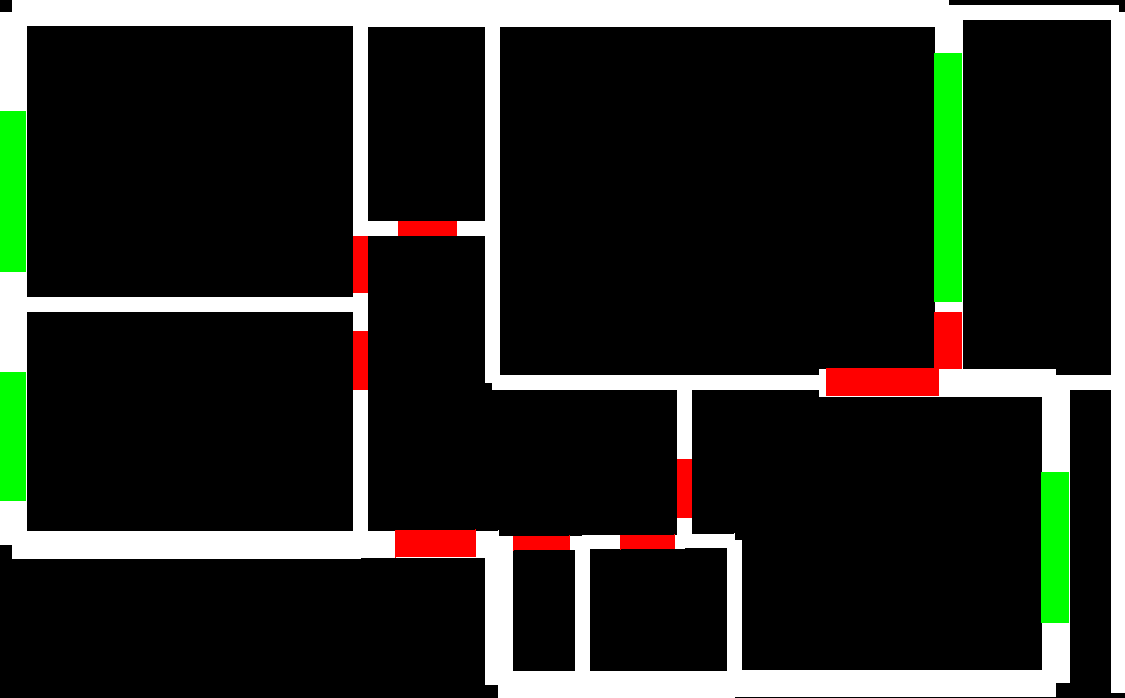

In [309]:
post_processor = WallPostProcessing()
for segment_results,symbol_results in zip(segment, symbol):
    for floor_segment,symbol_bbox in zip(segment_results, symbol_results):
        graph, coords, coord_edges = post_processor(floor_segment, symbol_bbox)
        print(post_processor.pixel_per_meter)
        # show(post_processor.mask)
        skel = np.concatenate((post_processor.skel[:,:,None], post_processor.skel[:,:,None], post_processor.skel[:,:,None]), axis=2)
        for coord in coords:
            a = 5
            skel[coord[0]-a:coord[0]+a,coord[1]-a:coord[1]+a] = np.random.rand(1, 3)
        # colors = np.random.rand()
        show(post_processor.room_mask)
        show(skel)
        display(draw_skel(coords, coord_edges, post_processor.size))